## Generator classes

### Example #1: Bit field objects

![opcode](bitfield.png)

Under the hood:

In [1]:
def generator_class_snippet(): # Generator class body snippet
    @blackbox
    def bitslice(val):
        """A bit slicing and comparator logic. Note that the `val` argument is a yosys
        Signal object, unlike a HLS signal object from a @hls/@component entity"""
        @inference(yosys)
        def implementation(module, sm):
            n = self.msb - self.lsb + 1
            sm.q = module.addSignal(None, 1)
            portion = val.extract(self.lsb, n)
            c = ConstSignal(self.val, n)
            identifier = yosys.new_id(node, "cmp")
            module.addEq(identifier, c, portion, sm.q, False)

        return implementation

    return bitslice(a)

Source code of yosys implementation specific bitfields extension: [bitfields.py](../utils/bitfields.py)

### Example 'opcode' register:

![opcode](bitfield.png)

Define a bit field 'inline' object:

In [2]:
import config
from bitfields import Bitfield

# Create bit field constants (lsb, msb, value):

BF_A = Bitfield(2, 4, 3)
BF_B = Bitfield(5, 7, 5)
BF_B1 = Bitfield(5, 7, 2)

Now generate a value by logic combination of the Bitfield constants:

In [3]:
from myhdl import *

v = intbv(int(BF_A | BF_B | 2)) # Casting constant integer
hex(v)

'0xae'

To obtain the actual value of the bitfield slice:

In [4]:
v[BF_B.as_slice()]

intbv(5)

To check if the slice portion of the bitfield is matching its given constant value:

In [5]:
BF_B(v), BF_B1(v)

(True, False)

From software perspective: Generate a `Bitfield` object that serves as:
* An inline instance of a hardware object with one output when called as function
* A constant when casted to integer

### Example bitfield decoder

In [6]:
@block
def bfdecode0(clk, reset, op, q, z):   
    @always_seq(clk.posedge, reset)
    def worker():
        "Bit field decoder for `op`"
        if BF_B(op): # Instance!
            if BF_A(op): # Instance!
                q.next = 2
            else:
                q.next = 1
        else:
            q.next = 3
            
    @always_comb
    def assign():
        z.next = BF_B1(op) # Instance!
        
    return instances()

**Note:** `# Instance!` denotes: We are creating *inline* logic. The RTL result is shown below

## Parametrizeable top level design


### Bitfield example:

Testing the above bit field scenario:

In [7]:
from myhdl.conversion.yshelper import Implementation

class MyImpl(Implementation):
    """Test implementation"""

In [8]:
@blackbox
def test_design(unit):
    """A test design (virtual board)"""
    clk = Signal(bool(0))
    z = Signal(bool(0))
    op = Signal(intbv()[16:])
    d = Signal(intbv()[3:])
    
    reset = ResetSignal(1, 1, True)

    inst_unit = unit(clk, reset, op, d, z)
    
    @inference(MyImpl)
    def rtl(design, top_name):
        inst_unit.convert("yosys_module", design, name="unit")
        
        return design

#     @inference(MyCoSimulation)
#     def mysim(design, top_name):
#          ...

    # Non-synthesis (sim only) section:
    @instance
    def startup():
        yield delay(8)
        reset.next = 0
        yield clk.negedge
        for v in [BF_B, BF_A, BF_A | BF_B1, BF_A | BF_B]:
            op.next = int(v)
            yield clk.negedge
            print("%02x" % d, z)
        yield clk.posedge

        raise StopSimulation
 
    @always(delay(2))
    def clkgen():
        clk.next = not clk

    return instances(), rtl

### Implementing the design

In [9]:
@block
def bfdecode0(clk, reset, op, q, z):   
    @always_seq(clk.posedge, reset)
    def worker():
        "Bit field decoder for `op`"
        if BF_B(op): # Instance!
            if BF_A(op): # Instance!
                q.next = 2
            else:
                q.next = 1
        else:
            q.next = 3
            
    @always_comb
    def assign():
        z.next = BF_B1(op) # Instance!
        
    return instances()


impl = test_design(bfdecode0)
design = impl.implement("rtl", "unit")

Implementation: Test implementation
CREATE Module: 'unit'
Adding module with name: bfdecode0_1_1_16_3_1
CONVERT_RTL tree >>>>>> 'UNIT_WORKER' 
CONVERT_RTL tree >>>>>> 'UNIT_ASSIGN' 
DONE instancing submodules


Generating RTL image...
Display...


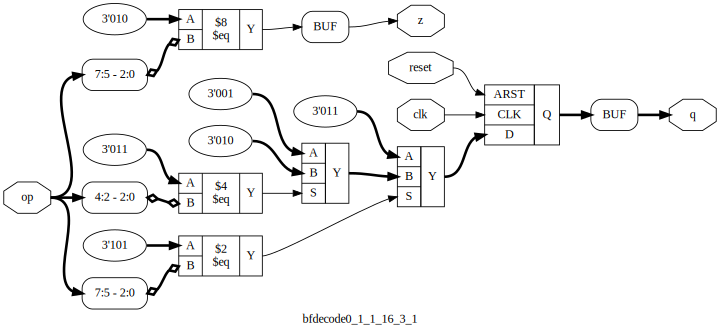

In [10]:
from ys_aux import to_svg
display(to_svg(design))

### Simulation

Run the top level blackbox as MyHDL simulation:

In [11]:
tb = test_design(bfdecode0)
tb.config_sim(trace=True)
tb.run_sim()
tb.quit_sim()

01 False
03 False
03 True
02 False


In [12]:
import wavedraw; import nbwavedrom
TB = "test_design";
waveform = wavedraw.vcd2wave("test_design.vcd", TB + '.clk', None)
nbwavedrom.draw(waveform)

### Next: [Hardware programming](hwprog_setup.ipynb)